# Timeseries forecasting for M.L practitioners<br> (and why you should probably use Random Forests for it)
[Back to index](../index.html)

Timeseries forecasting is the problem of estimating the future value of a process (e.g. how many cars a dealership will sell next month) based on historic data (such as how many cars the dealership has sold every month for the past years). Additional data could be incorporated for the predictive task (e.g. internet searches related to buying cars) but this is beyond the scope of basic timeseries forcasting (and this post).

### M.L. practitioners tend to overlook timeseries forecasting
Timeseries forecasting is an interesting problem related to Machine Learning (M.L.). It is also a problem that M.L. practitioners love to ignore. Let's take a look at some of the standard textbooks for M.L.
- [Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)
- [C.M. Bishop's Pattern Recognition and Machine Learning](https://www.amazon.com/Pattern-Recognition-Learning-Information-Statistics/dp/0387310738)
- [A. Smola's Introduction to Machine Learning](http://alex.smola.org/drafts/thebook.pdf)
- [K.P. Murphy's Machine Learning: A Probabilistic Perspective](https://www.amazon.com/Machine-Learning-Probabilistic-Perspective-Computation/dp/0262018020)

None of them really cover timeseries forecasting as a problem in its own right. With the occasional exception (in C.M. Bishop's and K.P. Murphy's books) of mentioning that a model could potentially be used for timeseries forcasting (e.g. HMMs) but that's about it.

### Traditional forecasting methods seem outdated
Traditional forecasting methods (such as ARIMA) are typically covered by statistics-oriented books such as [Forecasting Principles and Practice](https://otexts.org/fpp2/stationarity.html). Even though these books provide a good introduction to theory and basic predictive techniques the predictive models used seem rather simplistic to the contemporary M.L. practitioner. For example, you have probably heard statistics-oriented people claiming (in 2018) that Logistic Regression is a state of the art method for classification. You probably haven't heard an M.L.-oriented person saying something similar.

### M.L. is better suited for predictive tasks than statistical approaches
The focus of statistical methods is often to study and interpret systems rather than make accurate predictions. On the other hand, the first priority of M.L. methods is usually predictive performance even if it comes at the cost of a less interpretable model (ever heard of neural nets?). This does not mean in any way that traditional statistics are inferior to M.L., it's just a matter of priorities.

### The purpose of this article
This article was written with three main reasons in mind:
1. to introduce the problem of forecasting to the M.L. practitioner who has heard about it, but never really encountered it in practice.
2. to find out if a traditional M.L. method (Random Forest) performs better than simple traditional forecasting approaches (persistence model, ARIMA, Seasonal ARIMA) on a typical timeseries forecasting dataset.
3. to provide convenient "copy-paste-able" code that can be adapted for other forecasting tasks (hopefully with attribution and a reference to this article, if one would be so kind).

### What this article is not
This article is not an exhaustive comparison between timeseries foreasting methods (e.g. [ARCH/GARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity) methods are not covered).

### The dataset
We will use the car sales dataset availabe at [datamarket](https://datamarket.com/data/set/22n4/monthly-car-sales-in-quebec-1960-1968) which covers the monthly sales of cars in Quebec from 1960 to 1968.

Month
1960-01-01     6550
1960-02-01     8728
1960-03-01    12026
1960-04-01    14395
1960-05-01    14587
Name: Monthly car sales in Quebec 1960-1968, dtype: int64


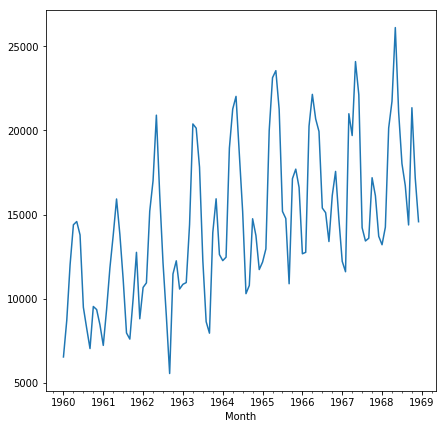

data for 108 months (9.0 years)


In [16]:
#load and plot the data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import autocorrelation_plot, lag_plot
import warnings
warnings.filterwarnings('ignore')
dpi = 100 #for saving plots to file
ndigits=4#number of digits to round-up for plotting
figsize = (7,7)
# load dataset
# available at https://datamarket.com/data/set/22n4/monthly-car-sales-in-quebec-1960-1968
# squeeze=True to read series instead of data frame
series = pd.read_csv('monthly-car-sales-in-quebec-1960.csv',
                     header=0, index_col=0, parse_dates=True, squeeze=True)
# display first few rows
print(series.head(5))
# line plot of dataset
plt.figure(figsize=figsize)
series.plot()
plt.show()
print('data for',len(series),'months '+'('+str(len(series)/12)+' years)')

## Stationarity of a timeseries
As we can see the dataset consists of monthly sales of cars in Quebec for 9 years (1960 to 1968). Most models related to timeseries forecasting assume that the data is **stationary**. Intuitively this means that the properties of the data generating process to be modelled do not change over time. In practice **stationarity** usually means two very specific things
1. **The mean μ** of the time series is stationary (does not change significantly over time)
2. **The standard deviation σ** of the time series is stationary (does not change significantly over time)

### Checking for stationarity
There are two ways to check if a timeseries is stationary
1. **Visual inspection** of the rolling mean and standard deviation
2. **Augmented Dickey-Fuller (ADF) test**: a statistical test for stationarity

#### Rolling statistics
The rolling mean of a timeseries for timepoint i is simply for a window size W is simply the mean of the previous W time steps. For example the rolling mean of timepoint i for W=3 is: rollmean(t<sub>i</sub>) = mean(t<sub>i-1</sub>,t<sub>i-2</sub>,t<sub>i-3</sub>). The rolling standard deviation for the same example is defined simiarly as rollstd(t<sub>i</sub>) = std(t<sub>i-1</sub>,t<sub>i-2</sub>,t<sub>i-3</sub>).

#### 1. Visual inspection for stationarity can be unreliable
A time series is "visually stationary" if the rolling mean and rolling standard deviation do not significantly change over time. However, plots of these statistics can be qualitatively affected by plotting properties such as aspect ratio. Let's plot the same series (and its corresponding statistics) below.

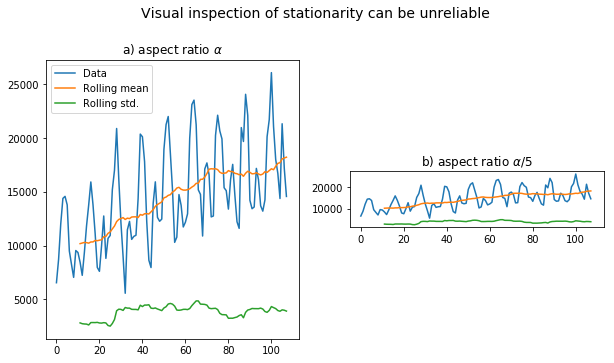

In [17]:
window=12
rolmean = series.rolling(window).mean()#rolling mean
rolstd = series.rolling(window).std()#rolling standard deviation
xlim = (-5,len(series)+5)

#now plot the same series using different aspect rations
plt.figure(figsize=(10,10))
plt.subplots_adjust(top=1.3)#need to manually adjust
plt.suptitle("Visual inspection of stationarity can be unreliable", fontsize=14)
plt.subplot(1,2,1,aspect=0.005)
plt.plot(series.values,label='Data')
plt.xlim(xlim)
plt.title(r'a) aspect ratio $\alpha$')
plt.plot(rolmean.values,label='Rolling mean')
plt.plot(rolstd.values,label='Rolling std.')
plt.legend()
plt.subplot(1,2,2,aspect=0.005/5)
plt.plot(series.values,label='Data')
plt.xlim(xlim)
plt.title(r'b) aspect ratio $\alpha/5$')
plt.plot(rolmean.values,label='Rolling mean')
plt.plot(rolstd.values,label='Rolling std.')
#plt.tight_layout()
plt.show()

As we can see above, in plot (a) the timeseries does not seem to be stationary since the rolling mean and std. appear to change over time. However the same plot viewed in a different aspect ratio suggests that the time series could be stationary. Plotting a series is good practice to get some intuition regarding the problem at hand, but we clearly need a better way to decide whether a timeseries is stationary or not.

#### 2. Augmented Dickey-Fuller (ADF) test
The ADF test checks the null hypothesis H0 that the series is not stationary against the alternative hypothesis H1 that it is. As a result, if the corresponding p-value of the ADF test is smaller than a threshold (e.g. < 5%) we can conclude that the timeseries is stationary. The ADF test is available in Python from the statsmodels package 

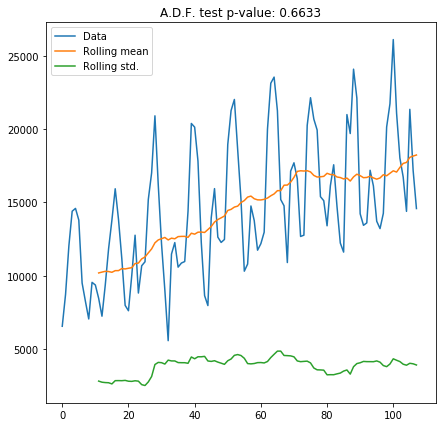

In [18]:
from statsmodels.tsa.stattools import adfuller #Dickey Fuller test

#run the ADF test
adf = adfuller(series.values.flatten())#Need to reshape s from (108,1) to (108,)
adf_stat = adf[0]#test statistic
adf_pval = adf[1]#p-value

#plot the results
plt.figure(figsize=figsize)
plt.plot(series.values,label='Data')
plt.plot(rolmean.values,label='Rolling mean')
plt.plot(rolstd.values,label='Rolling std.')
plt.xlim(xlim)
plt.legend()
plt.title('A.D.F. test p-value: '+str(np.round(adf_pval,ndigits)))
plt.show()

the p-value of the ADF test is 0.663 (larger than 0.05) so we conclude that the timeseries is **not stationary** since the Null hypothesis of the ADF test is not rejected. We will need to pre-process our data in a way that it is stationary in order to proceed any further with the analysis.

### Enforcing stationarity
There are many ways to convert a timeseries into a stationary form. The two simplest methods according to [Forecasting Principles and Practice](https://otexts.org/fpp2/stationarity.html) are:
1. **Log transform**, which helps to stabilize the variance
2. **Differencing**, which helps to stabilize the mean

Log transform is rather straight forward, while differencing refers to subtracting a lagged version of the timeseries from itself (with a lag of L timepoints). First order differencing refers to using a lag of L=1 so each timepoint x' of the differenced series would be x'<sub>t</sub> = x<sub>t</sub>-x<sub>t-1</sub>.

Let's enforce stationarity by log transform and differencing and perform the ADF test again.

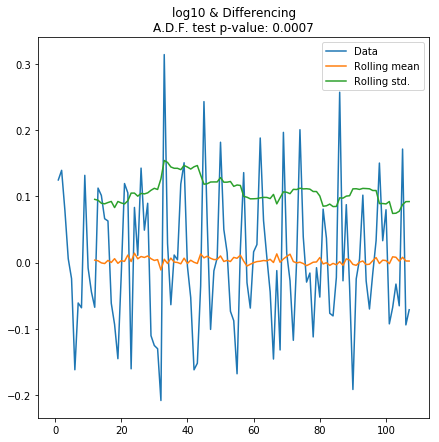

In [19]:
#Determing rolling statistics with pandas functions
window = 12#one year window

#Make series stationary by applying log10 and then differencing
def perform_stat_transform(series):
    series_stat=np.log10(series)#log transform
    series_stat = series_stat-series_stat.shift(1)#differencing: subtract previous timepoint
    return(series_stat)

series_stat=perform_stat_transform(series)

#Recalculate statistics
rolmean_stat = series_stat.rolling(window).mean()#rolling mean
rolstd_stat = series_stat.rolling(window).std()#rolling standard deviation

#redo ADF test
#need to drop NaN otherwise adfuller will crash during SVD
adf = adfuller(series_stat.dropna().values.flatten())#Need to reshape s from (108,1) to (108,)
adf_stat = adf[0]
adf_pval = adf[1]
#first 'window' values e.g. first 12 values of rolling statistics will be NaN
xlim = (-5,len(series_stat)+5)

#Including A.D.F. test p-value
plt.figure(figsize=figsize)
plt.plot(series_stat.values,label='Data')
plt.plot(rolmean_stat.values,label='Rolling mean')
plt.plot(rolstd_stat.values,label='Rolling std.')
plt.xlim(xlim)
plt.legend()
plt.title('log10 & Differencing\nA.D.F. test p-value: '+str(np.round(adf_pval,ndigits)))
plt.show()

We can see that the series looks stationary (like random noise with no trends) and the p-value of the ADF test is now < 0.0007 suggesting that the timeseries is stationary. We are ready to proceed further with modelling and forecasting the timeseries.

### Reverting the timeseries to original scale

While the transformed timeseries is good for training a model, in the end we would like to view our predictions in the original scale e.g. number cars sold per month, which makes intuitive sense. If we predict that the logged differentiated value of cars sold next month is 0.3 it makes no sense intuitively. It would also make more sense to calculate performance metrics of our prediction (e.g. Mean Absolute Error) in the original scale. To revert the transformation first we need to revert differencing using the cumsum() function of pandas and then simly exponentiating to undo the log scale, as follows:


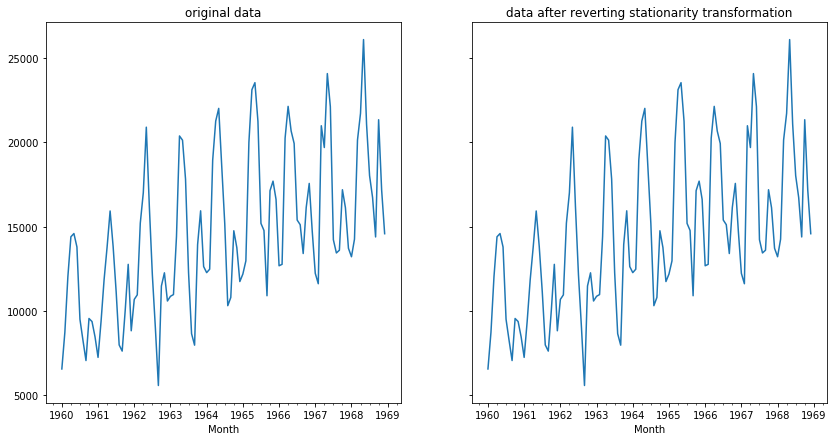

In [20]:
#Let's define a function for reverting the transform
def revert_stat_transform(s,first_value):
    s_reconstructed = s.copy()#start with the transformed stationary series
    s_reconstructed.iloc[0]=first_value#fill-in the first value which was NaN due to differencing
    s_reconstructed=np.power(10,s_reconstructed.cumsum())#undo differencing and log
    return(s_reconstructed)

#check that it works
series_reconstructed = revert_stat_transform(series_stat,np.log10(series).iloc[0])
assert np.abs(series_reconstructed-series).max()<10**-9#numerically they are practically the same

fig, axes = plt.subplots(1,2,figsize=(14,7),sharey=True,sharex=True)
#plot the original series
series.plot(ax=axes[0])
axes[0].set_title('original data')
#plot the reconstructed data
series_reconstructed.plot(ax=axes[1])
axes[1].set_title('data after reverting stationarity transformation')
plt.show()

## Validating a forecasting method

### Training, Validation and Test sets
We will split the available data into training, validation and test sets. The purpose of which are:
- **Training set**: used as historic data to train our model on
- **Validation set** (optional): Used for finetuning the model parameters. The model parameters that result in the best model for the validation set will be selected in the final model.
- **Test set**: will be used to assess the predictive capability of our model. **Must only be used once per model, after all model parameters are fixed using the train and validation sets**. The test set must not be used for model tuning otherwise the model assessment will be optimistic (overfitting) due to information leakage from the test set.

For the dataset at hand we will use the first 7 years (1960 to 1966) for training, one year (1967) for validation and one year (1968) for testing.

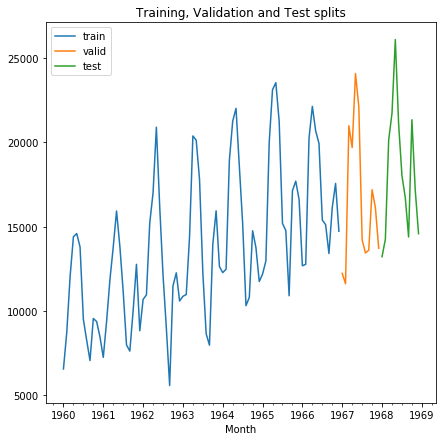

In [21]:
#indices of training, validation and test splits
ix_train = np.arange(0,12*7)#fist 7 years (1960 to 1966)
ix_valid = np.arange(12*7,12*8)#1967
ix_test = np.arange(12*8,12*9)#1968

plt.figure(figsize=figsize)
series.iloc[ix_train].plot(label='train')
series.iloc[ix_valid].plot(label='valid')
series.iloc[ix_test].plot(label='test')
plt.title('Training, Validation and Test splits')
plt.legend()
plt.show()

The breaks in the plot above between the lines of the different splits are just a plotting artifact.

### Rolling Forecast
Unlike traditional machine learning where the predictions are generated once (in a batch manner), for timeseries it makes sense to provide new data to the model, as soon as new data it becomes available. For example if 1968 is our test set and we want to predict the value of April 1968, it makes sense to use the true values of January, February and March 1968 before making our prediction for April. Rolling forecasts are more accurate (since we use true values as model input) but they come at the cost of patience (since we have to wait until the very last minute until these values become available). Rolling forecast typically looks one timestep ahead but it can be modified to predict 2 or more steps in the future.

Below is a visual illustration of a rolling forecast for predicting 1 or 3 steps ahead:

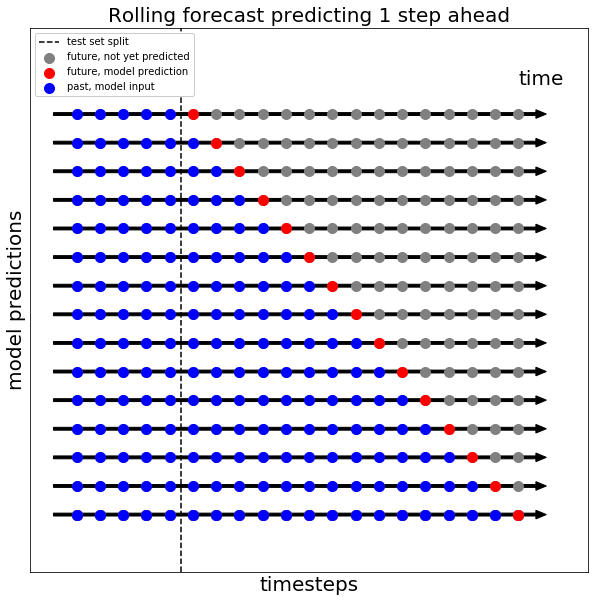

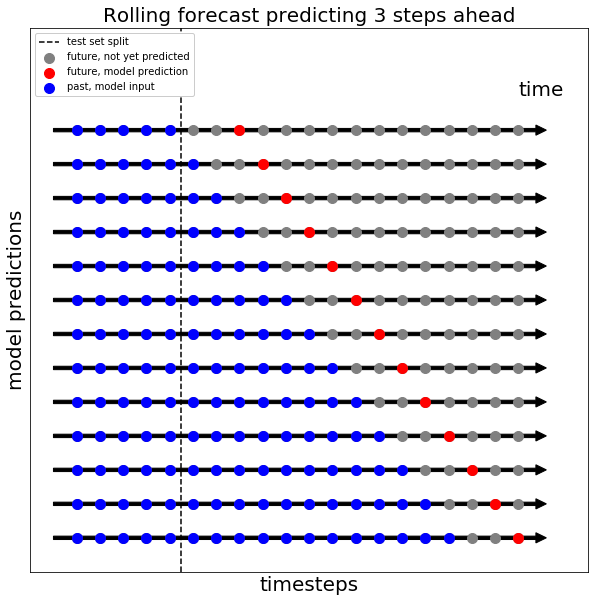

In [22]:
#Note: this codes simply produces the illustrational plots below, there's no practical function to it.

thresh=5
datapoints = np.arange(20)
N=len(datapoints)
width=0.1
plt.figure(figsize=(10,10))
#plot these for the legend labels only
plt.scatter(datapoints,[0]*len(datapoints),c='gray',zorder=2,s=100,label='future, not yet predicted')
plt.scatter(datapoints,[0]*len(datapoints),c='red',zorder=2,s=100,label='future, model prediction')
plt.scatter(datapoints,[0]*len(datapoints),c='blue',zorder=2,s=100,label='past, model input')
#do the actual plots
for i in range(0,N-thresh):
    plt.arrow(x=0-1,y=i,dx=N+1.2,dy=0,length_includes_head=True,width=width,color='black')
    plt.scatter(datapoints,[i]*len(datapoints),c='gray',zorder=2,s=100)
    plt.scatter(datapoints[:-(i+1)],[i]*len(np.array(datapoints[:-(i+1)])),c='blue',zorder=2,s=100)
    plt.scatter(datapoints[-(i+1)],[i],c='red',zorder=2,s=100)
plt.axvline(x=thresh-0.5,color='black',linestyle='--',label='test set split')
plt.xlim(-2,N+2)
plt.ylim(-2,N-thresh+2)
plt.text(19,N-thresh,'time',fontsize=20)
plt.xticks([])
plt.yticks([])
plt.xlabel('timesteps',fontsize=20)
plt.ylabel('model predictions',fontsize=20)
lgd=plt.legend(loc='upper left',framealpha=1)#not transparent
plt.title('Rolling forecast predicting 1 step ahead',fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
#plot these for the legend labels only
plt.scatter(datapoints,[0]*len(datapoints),c='gray',zorder=2,s=100,label='future, not yet predicted')
plt.scatter(datapoints,[0]*len(datapoints),c='red',zorder=2,s=100,label='future, model prediction')
plt.scatter(datapoints,[0]*len(datapoints),c='blue',zorder=2,s=100,label='past, model input')
#do the actual plots
for i in range(2,N-thresh):
    plt.arrow(x=0-1,y=i,dx=N+1.2,dy=0,length_includes_head=True,width=width,color='black')
    plt.scatter(datapoints,[i]*len(datapoints),c='gray',zorder=2,s=100)
    plt.scatter(datapoints[:-(i+1)],[i]*len(np.array(datapoints[:-(i+1)])),c='blue',zorder=2,s=100)
    plt.scatter(datapoints[-(i+1-2)],[i],c='red',zorder=2,s=100)
plt.axvline(x=thresh-0.5,color='black',linestyle='--',label='test set split')
plt.xlim(-2,N+2)
plt.ylim(-2+3,N-thresh+2)
plt.text(19,N-thresh,'time',fontsize=20)
plt.xticks([])
plt.yticks([])
plt.xlabel('timesteps',fontsize=20)
plt.ylabel('model predictions',fontsize=20)
lgd=plt.legend(loc='upper left',framealpha=1)#not transparent
plt.title('Rolling forecast predicting 3 steps ahead',fontsize=20)
plt.show()

### Using MAE as a performance metric

To quantify the performance of a predicted timeseries s<sub>pred</sub> compared to the original series s<sub>true</sub> we will use the Mean Absolute Error (MAE) which simply is:

**MAE = np.mean(np.abs(s<sub>true</sub>-s<sub>pred</sub>))**

## Forecasting model 1: Setting a baseline with a persistence model

A persistence model (also called a lag model) is the simplest forecasting model we can use. It assumes that the next value of the timeseries x<sub>t</sub> will be the same as a previous timepoint: x<sub>t</sub> = x<sub>t-L</sub> where L the lag value. Usually L=1 is used which assumes that the value for next timepoint will be the same as the current one. If there is strong seasonality in the data, perhaps another value for L would make more sense. For this example, L=12 would assume that the predicted value of car sales for e.g. April 1968 would be the equal to the value of April 1967 (12 months ago).


While a persistence model is naive, it can be a useful baseline when assessing the performance of other, more elaborate models. In general a more complicated model is worth the effort only if it manages to outperform the simplest model we can use, in this case the persistence model. Next, we will "train" a persistence model for our example dataset. By training in this case we refer to finding the best lag value L that leads to the best predictive performance on the validation set. Then we will use this lag value L<sub>best</sub> to assess the model's performance using a rolling forecast on the test set.

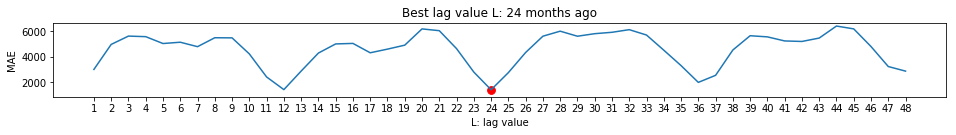

In [23]:
#first let's just define a function to compute MAE (theres also a sklearn implementation)

def MAE(s_true,s_pred):
    return(np.mean(np.abs(s_true-s_pred)))

#search for the best value of n up to 4 years back (48 months)
lag_values = np.arange(1, 4*12+1)#1 to 48 months

scores = []
for L in lag_values:
    #rolling forecast
    predictions = []
    #print('Lag L:',L)
    for i in np.arange(len(ix_valid)):
        #make prediction
        yhat = series.iloc[ix_valid[i]-L]#no need to use stationary series for persistence model
        predictions.append(yhat)
    #save performance
    mae = MAE(series.iloc[ix_valid], predictions)
    scores.append(mae)
    #print('p=%d MSE:%.3f' % (L, mae))

#convert scores to array
scores = np.array(scores)

#calculate the best persistence value (min loss)
ix_min = np.where(scores==np.min(scores))[0]
L_best = lag_values[ix_min][0]#Lag value with the best (minimum) loss on the validation set

# plot scores over persistence values
plt.figure(figsize=(16,3))
plt.subplot(2,1,1)
plt.plot(lag_values, scores)
plt.scatter(L_best,scores[ix_min],c='red',s=60)
plt.title('Best lag value L: '+str(L_best)+' months ago')
plt.ylabel('MAE')
plt.xlabel('L: lag value')
plt.xticks(lag_values)#show all values on x-axis
#so the best value to predict t_{+1} is the value at t_{-12} -> 12 months back
plt.show()

We can see that the best lag value according to the validation dataset is 24 months (2 years) ago. Of course 12 months ago comes pretty close and we could choose it, as well. This shows that our data is strongly affected by seasonality. We will now use L=24 and make predictions for our test set, to assess the predictive performance of our method on unknown data

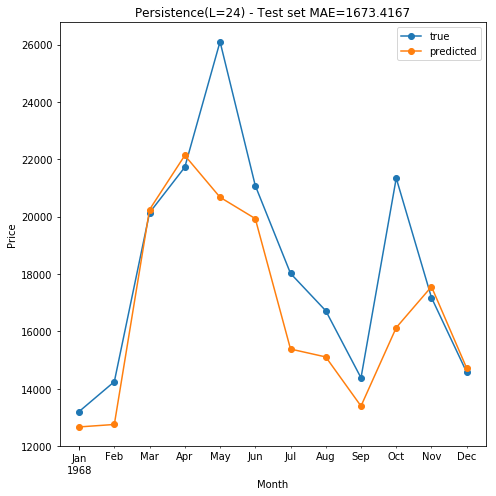

In [24]:
L=L_best
#rolling forecast
predictions_test = []
#print('Lag L:',L)
for i in np.arange(len(ix_test)):
    #make prediction
    yhat = series.iloc[ix_test[i]-L]#no need to use stationary series for persistence model
    predictions_test.append(yhat)
#save performance
mae_test = MAE(series.iloc[ix_test], predictions_test)
#print('p=%d MSE:%.3f' % (L, mae_test))

#create prediction as a series object
series_predicted_persistence=series.iloc[ix_test].copy()
series_predicted_persistence.iloc[:]=predictions_test

#plot predictions vs true values
plt.figure(figsize=figsize)
series.iloc[ix_test].plot(label='true',marker='o')
series_predicted_persistence.plot(label='predicted',marker='o')
#plt.plot(predictions_test_persistence, 'r+-', label='predicted')
plt.title('Persistence(L='+str(L_best)+') - '+'Test set MAE='+str(np.round(mae_test,ndigits)))
plt.ylabel('Price')
#plt.xlabel('Timepoint')
plt.legend()
plt.tight_layout() 
plt.show()


We can see that a simple persistence model does quite a good job for predicting a rolling forecast one step (month) ahead in time. However it performs poorly for May, July and October 1968. We will see if more elaborate models do better.

## Forecasting model 2: ARIMA

ARIMA models are one of the most frequently used model types in time-series forecasting. Their main assumption is that the value of the current timepoint is correlated to the values of recent previous timepoints (autocorrelation), thus these previous timepoints can be used as predictors. Additional information can be found in [Forecasting Principles and Practice](https://otexts.org/fpp2/arima.html)

Unlike persistence, ARIMA models require the data to be stationary, that is why we bothered enforcing stationarity on the timeseries in a previous step. An ARIMA(p,d,q) model depends on 3 parameters:
- p: order of the autoregressive (AR) model. For e.g. p=3, x<sub>t</sub> will be predicted based on x<sub>t-1</sub>, x<sub>t-2</sub> and x<sub>t-3</sub>
- d: order of differencing. How many times differencing will be performed on the series in order to make it stationary. d is usually set to one. In our case we have already enforced stationarity on the series, so we will set d to zero.
- q: order of moving average (MA) model. For e.g. q=2, x<sub>t</sub> will be predicted based on forecasting errors e<sub>t-1</sub>, e<sub>t-2</sub> of previous time steps.

### Estimating p, d, q hyperparameters
As discussed above, we will set d=0 since the transformed series is already stationary. We will choose the values of p and q based on the [ACF and PACF plots](https://otexts.org/fpp2/non-seasonal-arima.html)
- p is defined using the Partial AutoCorrelation Function (PACF) plot. We choose the value of p at which there is a significant spike in the PACF and no other significant spikes occur after.
- q is defined using the AutoCorrelation Function (ACF) plot. We choose the value of q at which there is a significant spike in the ACF and no other significant spikes occur after.

Both PACF and ACF are implemented in the statsmodels python package.

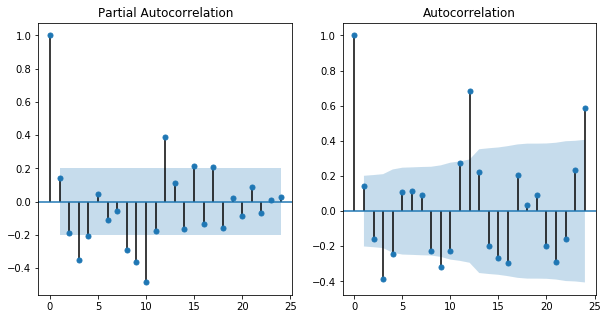

In [25]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#exclude the test set from hyperparameter tuning
ix_trainvalid = np.concatenate((ix_train,ix_valid))

fig, axes = plt.subplots(1,2,figsize=(10,5))
#only plot lags up to 24 timepoints (months) so that the plots are easier to read
plot_pacf(series_stat.iloc[ix_trainvalid].values[1:],ax=axes[0],lags=24)#[1:] to remove the NaN
plot_acf(series_stat.iloc[ix_trainvalid].values[1:],ax=axes[1],lags=24)#[1:] to remove the NaN
plt.show()

We can see above that the suggested values are:
- p=1 according the the PACF plot
- q=1 according to the ACF plot

So we will use an ARIMA(1,0,1) model. There are some additional spikes in the PACF and ACF plots, most prominently for lag=12 which suggests that there is a seasonality in the series that will not be captured by our model. We will get back to this later. Setting q=1 crashes the underlying ARIMA library for our data so we will use q=2 instead. Now let's train an ARIMA(1,0,2) model and predict on the test set.

p=24 MSE:3069.342


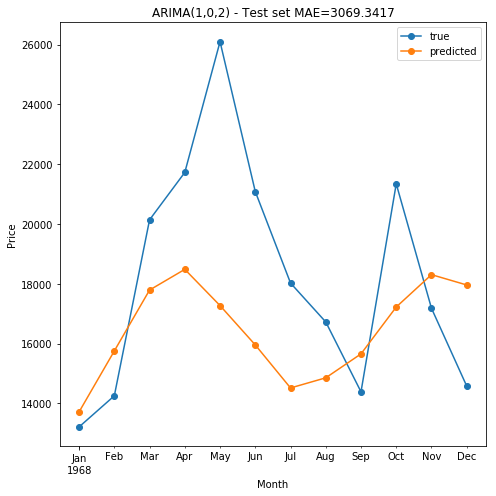

In [26]:
from statsmodels.tsa.arima_model import ARIMA

#set arima values
(p, d, q) = 1, 0, 2

#rolling forecast
predictions_test = []
#print('Lag L:',L)
for i in np.arange(len(ix_test)):
    #indices to fit model on. All data up to one timestep before the predicted value
    ix_fit=np.concatenate((ix_trainvalid,ix_test[:i])).astype('int')
    #make prediction
    arima_model = ARIMA(series_stat.iloc[ix_fit].values[1:], order=(p, d, q)).fit(trend='c',disp=0)
    #arima_model = ARIMA(series.iloc[ix_fit].values[1:].astype('float'), order=(p, d, q)).fit(trend='c',disp=0)
    yhat = arima_model.forecast(steps=1)[0]#predict the next step
    predictions_test.append(yhat)

#create prediction as a series object
series_predicted_arima=series.iloc[ix_test].copy()
series_predicted_arima.iloc[:]=predictions_test

#convert to original scale
series_predicted_arima = revert_stat_transform(series_predicted_arima,np.log10(series).iloc[ix_valid[-1]])

#save performance
mae_test = MAE(series.iloc[ix_test], series_predicted_arima)
print('p=%d MSE:%.3f' % (L, mae_test))

#plot predictions vs true values
plt.figure(figsize=figsize)
series.iloc[ix_test].plot(label='true',marker='o')
series_predicted_arima.plot(label='predicted',marker='o')
#plt.plot(predictions_test_persistence, 'r+-', label='predicted')
plt.title('ARIMA(1,0,2) - Test set MAE='+str(np.round(mae_test,ndigits)))
plt.ylabel('Price')
#plt.xlabel('Timepoint')
plt.legend()
plt.tight_layout() 
plt.show()

We can see that the ARIMA(1,0,2) model (MAE=3069.3417) **is quite worse than the persistence model** (which had MAE=1673.4167) in this case. This could be attributed to the seasonality which is present in the dataset and is not accounted for by the ARIMA model. It should be noted that playing around with different p,d,q parameters did not yield any significantly better results on the test set (and even if it did it would be a bad idea since we would have had used the test set to fine-tune model params). But it does suggest that bad predictive performance is a model problem and not an unfortunate selection of hyperparameters.

## Forecasting model 3: Seasonal ARIMA (SARIMA)

SARIMA models are ARIMA models that account for seasonality. Additional information can be found in [Forecasting Principles and Practice](https://otexts.org/fpp2/seasonal-arima.html). A SARIMA(p,d,q)(P,D,Q) model depends on 7 parameters (p,d,q) and (P,D,Q,s). The first set of (p,d,q) parameters is defined in the same manner as ARIMA models and a good set of hyperparameters is found by manual inspection of the PACF and ACF plots, following the same process for ARIMA models above. The second set of (P,D,Q,s) parameters accounts for seasonality.


A SARIMA model is fully identified by stating all parameters as SARIMA(p,d,q)(P,D,Q)<sub>s</sub>
### Estimating p, d, q hyperparameters for SARIMA
Same process as for ARIMA, we will set (p,d,q) to (1,0,2) as above.

### Estimating P, D, Q, s hyperparameters for SARIMA
We saw in the ACF And PACF above that there are spikes at lag=12 that hint at seasonality every 12 timepoints (months).
We will set the seasonality component s=12. Then we will set P=1 and Q=1 to account for the spikes in the PACF and ACF plot at the lag of 12. P=1 accounts for the spike at lag of 's' (and we set s=12), same logic for Q=1.

We will now fit a SARIMA(1,0,2)(1,0,1)<sub>12</sub> model and see how it performs:

Note: Experimenting with s=24 would be interesting, since that gave the best results for the persistece model. However SARIMA crashes for s=24 so we will stick to s=12.

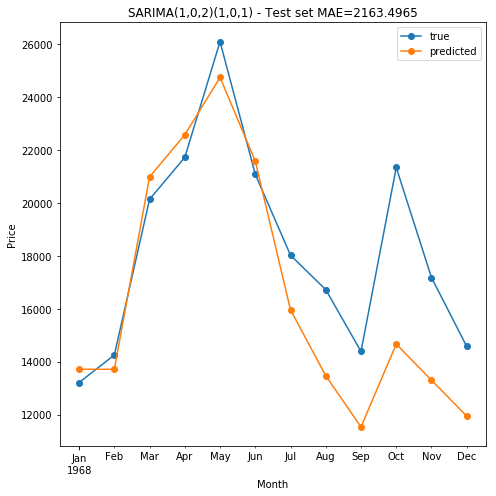

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#set arima values
(p, d, q) = 1, 0, 2
(P, D, Q, s) = 1, 0, 1, 12
#s is specific to SARIMAX, s=12 defines seasonality as 12 timepoints.

#rolling forecast
predictions_test = []
#print('Lag L:',L)
for i in np.arange(len(ix_test)):
    #indices to fit model on. All data up to one timestep before the predicted value
    ix_fit=np.concatenate((ix_trainvalid,ix_test[:i])).astype('int')
    #make prediction
    sarima_model = SARIMAX(series_stat.iloc[ix_fit].values[1:], order=(p, d, q),
                           seasonal_order=(P,D,Q,s)).fit(trend='c',disp=0)
    yhat = sarima_model.forecast(steps=1)[0]#predict the next step
    predictions_test.append(yhat)

#create prediction as a series object
series_predicted_sarima=series.iloc[ix_test].copy()
series_predicted_sarima.iloc[:]=predictions_test

#convert to original scale
series_predicted_sarima = revert_stat_transform(series_predicted_sarima,np.log10(series).iloc[ix_valid[-1]])

#save performance
mae_test = MAE(series.iloc[ix_test], series_predicted_sarima)

#plot predictions vs true values
plt.figure(figsize=figsize)
series.iloc[ix_test].plot(label='true',marker='o')
series_predicted_sarima.plot(label='predicted',marker='o')
#plt.plot(predictions_test_persistence, 'r+-', label='predicted')
plt.title('SARIMA(1,0,2)(1,0,1) - Test set MAE='+str(np.round(mae_test,ndigits)))
plt.ylabel('Price')
#plt.xlabel('Timepoint')
plt.legend()
plt.tight_layout() 
plt.show()

We can see that SARIMA (MAE=2163.4965) accounts for seasonality and does a much better job at forecasting than ARIMA (MAE=3069.3417), but surprisingly **is still worse that the simple persistence model** (MAE=1673.4167).

## Forecasting model 4: Random Forest for regression 

We will now use a standard M.L. practitioners tool: the random forest. We can treat time series forecasting as a simple (auto)regression problem where each value x<sub>t</sub> can be predicted from a function of lagged versions of itself x<sub>t-T</sub>, ..., x<sub>t-1</sub> where T the size of the autoregressive window that we look back in time.

This is a simple regression problem, so we can simply use a random forest to solve it. We will have to reshape the timeseries in a data matrix where the rows will be "time windows" that will include x<sub>t-T</sub>, ..., x<sub>t-1</sub> and the corresponding response variable for each row will be x<sub>t</sub>.

The size of the autoregressive window T is a hyperparameter, but since we know there is seasonality and T=24 was good for the persistence model, we will set T=24 for the random forest, as well. So we will use the 24 most recent timepoints as input to the random forest to predict the next timepoint.

Moreover the random forest does not strictly require stationarity, so we will fit the original (non-transformed) timeseries.

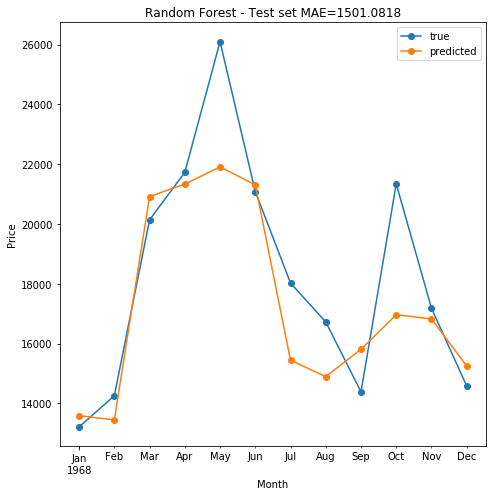

In [28]:
from sklearn.ensemble import RandomForestRegressor

T=24
rf = RandomForestRegressor(n_estimators=1000,max_features='auto',random_state=0,n_jobs=-1,criterion='mae')

#create data matrix X_train_valid and targets y_trainvalid
s = series.values#original timeseries
#s = series_stat.values[1:]#transformed timeseries
ntimepoints=len(s)-T
X=np.zeros((ntimepoints,T))
y=np.zeros(ntimepoints)
for i in range(ntimepoints):
    row=s[i:(i+T)]
    target=s[i+T]
    X[i,:]=row
    y[i]=target

assert np.array_equal(y,s[T:])#sanity check

#training and validation sets
X_trainvalid = X[:-12,:]
y_trainvalid = y[:-12]

#test set (last 12 timepoints)
X_test = X[-12:,:]
y_test = y[-12:]

#series.plot()
#plt.plot(y)
#plt.show()

#fit RF and predict on the test set
rf.fit(X_trainvalid, y_trainvalid)
predictions_test = rf.predict(X=X_test)

#create prediction as a series object
series_predicted_rf=series.iloc[ix_test].copy()
series_predicted_rf.iloc[:]=predictions_test

#convert to original scale
#series_predicted_rf = revert_stat_transform(series_predicted_rf,np.log10(series).iloc[ix_valid[-1]])

#save performance
mae_test = MAE(series.iloc[ix_test], series_predicted_rf)

#plot predictions vs true values
plt.figure(figsize=figsize)
series.iloc[ix_test].plot(label='true',marker='o')
series_predicted_rf.plot(label='predicted',marker='o')
#plt.plot(predictions_test_persistence, 'r+-', label='predicted')
plt.title('Random Forest - Test set MAE='+str(np.round(mae_test,ndigits)))
plt.ylabel('Price')
#plt.xlabel('Timepoint')
plt.legend()
plt.tight_layout() 
plt.show()

The random forest outperforms all other models in terms of predictive performance on the test set!

### RF automatically identifies seasonality as the most important feature(s)
Fitting a random forest automatically calculates the importance of every feature (Gini Importance). In this manner, we can look into the data and identify important features which will help interpret the model's behaviour. Let's plot the Gini importance of each feature according to our fitted random forest:

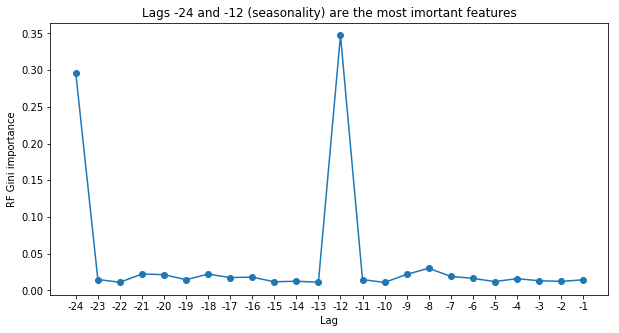

In [29]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(rf.feature_importances_)),rf.feature_importances_,marker='o')
plt.xlabel('Lag')
ticks=np.arange(len(rf.feature_importances_))
labels=np.arange(-T,0,1)
plt.xticks(ticks,labels)
plt.ylabel('RF Gini importance')
plt.title('Lags -24 and -12 (seasonality) are the most imortant features')
plt.show()

We can see that **the random forest automatically detects and leverages the seasonality in the data** since it identifies the lags -12 and -24 as the most important features, almost ingoring all other lags. This leads to exceptional model performance without any need of finetuning from the user! No other model we saw so far is capable of something similar.

## Conclusion

As we already saw, the Random Forest is the most accurate of all forecasting methods tested above. The absolute error of all methods on the held out test set is summarized in the figure below:

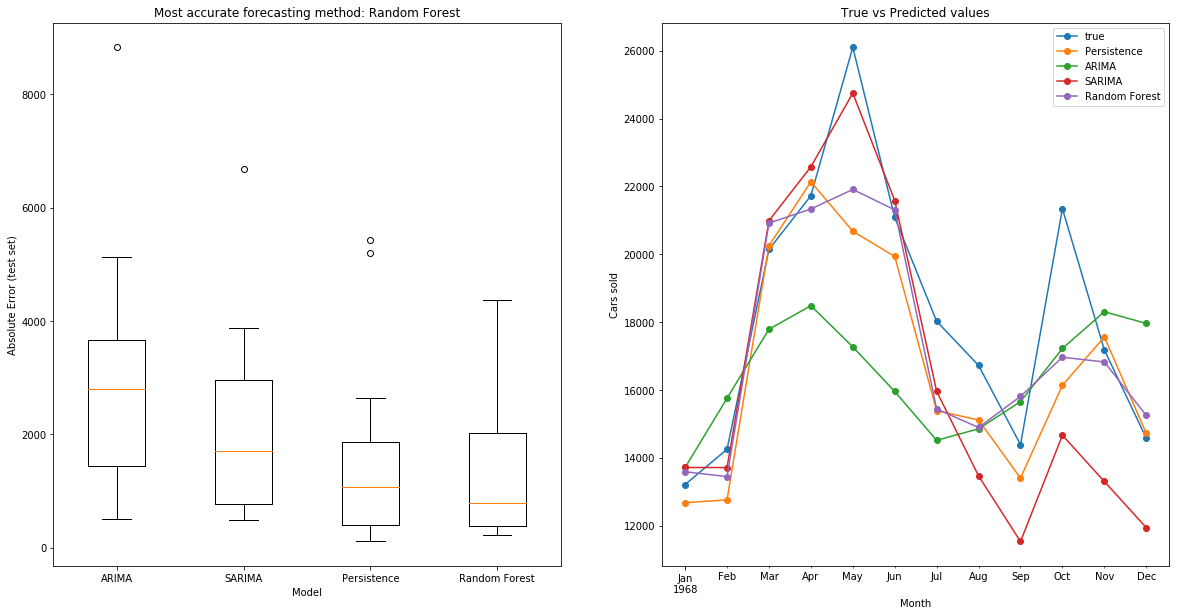

In [30]:
AE_persistence = np.abs(series.iloc[ix_test]-series_predicted_persistence)
AE_arima = np.abs(series.iloc[ix_test]-series_predicted_arima)
AE_sarima = np.abs(series.iloc[ix_test]-series_predicted_sarima)
AE_rf = np.abs(series.iloc[ix_test]-series_predicted_rf)
data = [AE_arima,AE_sarima,AE_persistence,AE_rf]
labels=['ARIMA','SARIMA','Persistence','Random Forest']
fig,axes=plt.subplots(1,2,figsize=(20,10))
#plot errors
#plt.violinplot(data)
axes[0].boxplot(data,labels=labels)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Absolute Error (test set)')
axes[0].set_title('Most accurate forecasting method: Random Forest')
#plot predictions
series.iloc[ix_test].plot(label='true',marker='o',ax=axes[1])
series_predicted_persistence.plot(label='Persistence',marker='o',ax=axes[1])
series_predicted_arima.plot(label='ARIMA',marker='o',ax=axes[1])
series_predicted_sarima.plot(label='SARIMA',marker='o',ax=axes[1])
series_predicted_rf.plot(label='Random Forest',marker='o',ax=axes[1])
#axes[0].set_xlabel('Model')
axes[1].set_ylabel('Cars sold')
axes[1].set_title('True vs Predicted values')
plt.legend()
plt.show()

While the Random Forest was the most accurate method, simple persistence was (surprisingly) a close second, beating traditional statistical approaches such as ARIMA and SARIMA. Maybe the results for these methods could be improved with semi-exhaustive hyper-parameter search but that that is not really an argument since Random Forest (and persistence) work nicely out of the box, while tuning ARIMA/SARIMA requires guessing parameters from the PACF/ACF plots and even for "good" parameter values these methods can crash while training (as happened above).

### Random Forest advantages in a nutshell
1. More accurate
2. Works nicely out of the box (this is a big disadvantage of ARIMA/SARIMA which require rather rigorous finetuning)
3. It automatically identifies relevant features!(related to the point above) which help with accuracy and model interpretability (we could see that seasonality is important without PACF/ACF plots)
4. Does not break when training (another disadvantage of ARIMA/SARIMA)
5. Is not sensitive to stationarity of the timeseries (or lack of it) 

## Additional Resources:
1. [Comparison of ARIMA and Random Forest time series models for prediction of avian influenza H5N1 outbreaks](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276)
2. [Forecasting Principles and Practice](https://otexts.org/fpp2/stationarity.html)
3. [A comprehensive beginner’s guide to create a Time Series Forecast (with Codes in Python)](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)
4. [Time Series Forecast Study with Python: Monthly Sales of French Champagne](https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/)
5. [Random Forest for Time Series Forecasting](https://www.ifweassume.com/2014/09/random-forest-for-time-series.html)

## Code availability
The code in this article is freely available (without any guarantee, to use at your own risk). Attribution and a link to this article are not strictly required, but would be appreciated.


